## Libraries

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')

## XGBoost

### Load data

In [4]:
df_train = pd.read_csv(f'./input/df_final_train_albert-large-v2-cls-ff-150-150-0.1_le_220_lr_1e-05_ep_7_ba_8-mse-0.3327.csv')
df_test = pd.read_csv(f'./input/df_final_test_albert-large-v2-cls-ff-150-150-0.1_le_220_lr_1e-05_ep_7_ba_8-mse-0.3327.csv')

In [5]:
x_train = df_train.drop(['price', 'log_price', 'latitude', 'longitude'], axis = 1)
y_train = df_train['log_price']

x_test = df_test.drop(['price', 'log_price', 'latitude', 'longitude'], axis = 1)
y_test = df_test['log_price']

print(f'Train: {x_train.shape}, {y_train.shape}')
print(f'Test: {x_test.shape}, {y_test.shape}')

Train: (50394, 69), (50394,)
Test: (12599, 69), (12599,)


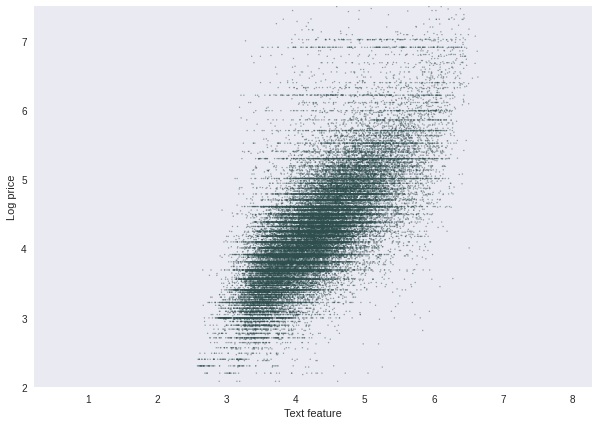

In [4]:
fig = plt.figure(figsize = (10, 7))
plt.scatter(
    df_train['text_feature'],
    df_train['log_price'],
    s = 2,
    alpha = 0.5,
    linewidths = 0,
    edgecolors = 'none',
    color = 'darkslategray'
)
plt.ylabel('Log price')
plt.xlabel('Text feature')
plt.axis('equal')
plt.axis([2, 6.5, 2, 7.5])
plt.grid()
plt.savefig('./output/pricevstext.pdf')
plt.show();

In [5]:
np.corrcoef(df_train['text_feature'], df_train['log_price'])

array([[1.        , 0.72381265],
       [0.72381265, 1.        ]])

### Hyperparameter tuning

In [6]:
train_xgb = xgb.DMatrix(x_train, label = y_train, missing = np.nan)
test_xgb = xgb.DMatrix(x_test, missing = np.nan)

In [23]:
num_rounds = []

def xgb_func(learning_rate, max_depth, min_child_weight, colsample_bytree, subsample):
    """Returns a 3-fold (stratified) cross-validated AUC for a parameter combination"""
    params = {       
        "max_depth": int(max_depth), 
        "colsample_bytree": colsample_bytree,
        "subsample": subsample,
        "min_child_weight": min_child_weight,
        "min_split_loss": 0,
        "learning_rate": learning_rate,
        "verbosity": 0,
        "reg_lambda": 1.2,
        "objective": "reg:squarederror",
        #"tree_method": "gpu_hist",
        "seed": 2020
    }        
    cv_result = xgb.cv(
        params,
        train_xgb,
        metrics = ["rmse"],
        num_boost_round = 10_000,
        early_stopping_rounds = 150,
        nfold = 3,
        show_stdv = False,
        verbose_eval = False,
        shuffle = True,
        seed = 2020
    )
    num_rounds.append(len(cv_result))
    rmse = cv_result["test-rmse-mean"].iloc[-1] # last entry is best iteration
    mse = -1.0 * (rmse**2)
    return mse

In [24]:
param_space = {
    "learning_rate": (0.05, 0.1),
    # model complexity
    "max_depth": (2, 6),
    "min_child_weight": (3, 10),
    # robustness to noise
    "colsample_bytree": (0.55, 0.85),
    "subsample": (0.55, 0.85)
}

optimizer = BayesianOptimization(
    f = xgb_func,
    pbounds = param_space
)

optimizer.maximize(
    init_points = 4,
    n_iter = 10,
    acq = "ei",
    random_state = 2020
)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.1777   |  0.5698   |  0.08554  |  3.523    |  9.763    |  0.7883   |
|  2        | -0.1731   |  0.7237   |  0.08     |  4.196    |  9.056    |  0.7314   |
|  3        | -0.1711   |  0.6598   |  0.06355  |  4.505    |  5.866    |  0.8348   |
|  4        | -0.1864   |  0.7063   |  0.06533  |  2.494    |  4.429    |  0.8117   |
|  5        | -0.1668   |  0.55     |  0.05     |  6.0      |  10.0     |  0.85     |
|  6        | -0.1704   |  0.8342   |  0.05816  |  5.982    |  5.279    |  0.5661   |
|  7        | -0.1698   |  0.7963   |  0.07835  |  5.953    |  7.236    |  0.828    |
|  8        | -0.1733   |  0.5545   |  0.09327  |  5.646    |  7.702    |  0.5872   |
|  9        | -0.1695   |  0.8294   |  0.07826  |  5.857    |  3.09     |  0.8341   |
|  10       | -0.1682   |  0.85     |  0.05     |  6.0

In [25]:
print(optimizer.max)

{'target': -0.16676224546844443, 'params': {'colsample_bytree': 0.55, 'learning_rate': 0.05, 'max_depth': 6.0, 'min_child_weight': 10.0, 'subsample': 0.85}}


### Training

In [21]:
learning_rate = 0.05#optimizer.max['params']['learning_rate']
colsample_bytree = 0.55#optimizer.max['params']['colsample_bytree']
max_depth = 6.0#optimizer.max['params']['max_depth']
min_child_weight = 10.0#optimizer.max['params']['min_child_weight']
subsample = 0.85#optimizer.max['params']['subsample']

params = {       
    "max_depth": int(max_depth),
    "colsample_bytree": colsample_bytree,
    "subsample": subsample,
    "min_child_weight": min_child_weight,
    "min_split_loss": 0,
    "learning_rate": learning_rate,
    "verbosity": 1,
    "reg_lambda": 1.2,
    "objective": "reg:squarederror",
    #"tree_method": "gpu_hist",
    "seed": 2020
}

model = xgb.train(
    params,
    train_xgb,
    num_boost_round = 2_300
)

### Evaluation

In [22]:
mean_squared_error(y_train, model.predict(train_xgb))

0.05822749155512295

In [23]:
y_pred = model.predict(test_xgb)
                                               
mean_squared_error(y_test, y_pred)

0.16514089680033575

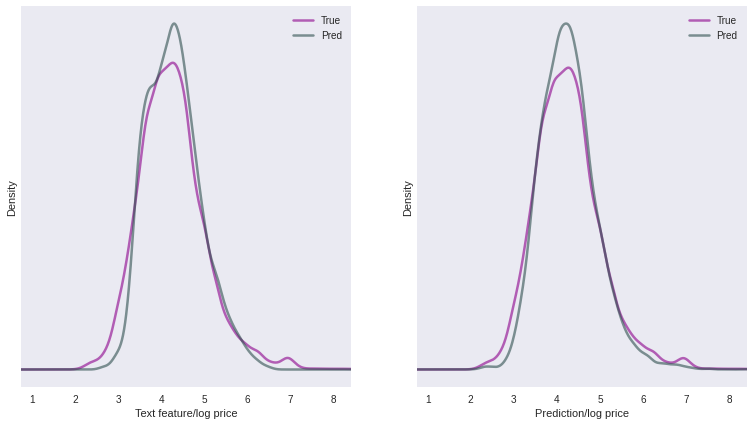

In [66]:
plt.figure(figsize = (13, 7))
plt.subplot(1, 2, 1)
df_test['log_price'].plot(kind = 'density', color = 'darkmagenta', alpha = 0.6, lw = 2.5)
df_test['text_feature'].plot(kind = 'density', color = 'darkslategray', alpha = 0.6, lw = 2.5)
plt.yticks([])
plt.xlim([0.75, 8.4])
plt.ylabel('Density')
plt.xlabel('Text feature/log price')
plt.legend(['True', 'Pred'])
plt.grid()
plt.subplot(1, 2, 2)
pd.Series(y_test).plot(kind = 'density', c = 'darkmagenta', alpha = 0.6, lw = 2.5)
pd.Series(y_pred).plot(kind = 'density', c = 'darkslategray', alpha = 0.6, lw = 2.5)
plt.xlim([0.75, 8.4])
plt.yticks([])
plt.ylabel('Density')
plt.xlabel('Prediction/log price')
plt.legend(['True', 'Pred'])
plt.grid()
plt.savefig('./output/gbmpreds.pdf', bbox_inches = 'tight');

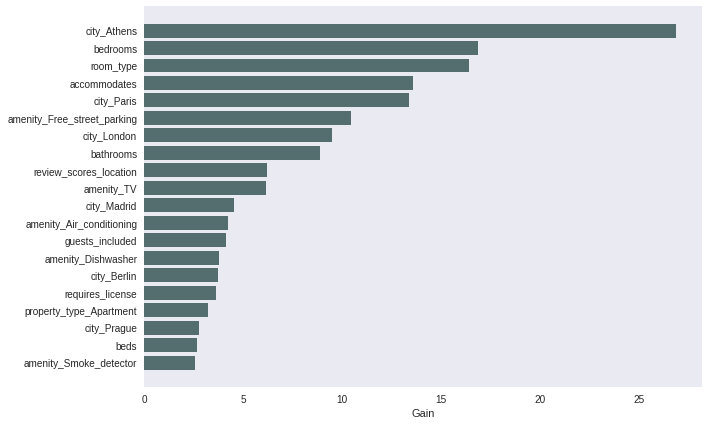

In [60]:
scores = model.get_score(importance_type = 'gain')

plt.figure(figsize = (10, 7))
imp_df = pd.DataFrame({"variables": list(scores.keys()), "gain": list(scores.values())})
imp_df = imp_df.sort_values("gain", ascending = False)
imp_df = imp_df[0:20]
imp_df = imp_df.sort_values("gain", ascending = True)
plt.barh(imp_df['variables'], imp_df['gain'], color = 'darkslategray', alpha = 0.8)
plt.xlabel("Gain")
plt.ylabel("")
plt.grid()
plt.savefig('./output/gbmfeatimp.pdf', bbox_inches = 'tight');

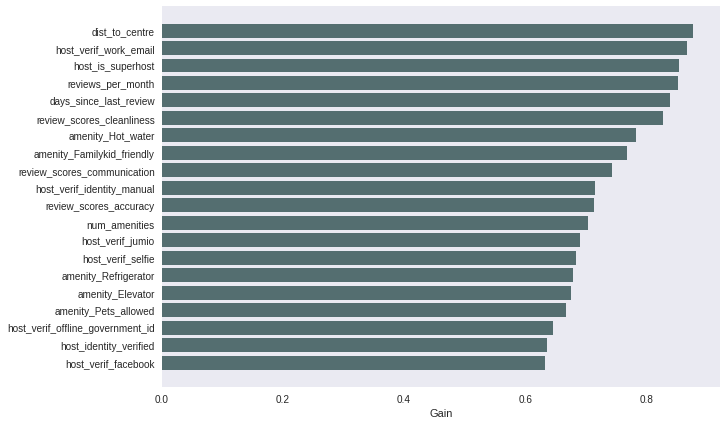

In [14]:
scores = model.get_score(importance_type = 'gain')

plt.figure(figsize = (10, 7))
imp_df = pd.DataFrame({"variables": list(scores.keys()), "gain": list(scores.values())})
imp_df = imp_df.sort_values("gain", ascending = False)
imp_df = imp_df[-20:]
imp_df = imp_df.sort_values("gain", ascending = True)
plt.barh(imp_df['variables'], imp_df['gain'], color = 'darkslategray', alpha = 0.8)
plt.xlabel("Gain")
plt.ylabel("")
plt.grid()

## OLS pre-processing

In [155]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [228]:
df_train = pd.read_csv(f'./input/df_final_train_albert-large-v2-cls-ff-150-150-0.1_le_220_lr_1e-05_ep_7_ba_8-mse-0.3327.csv')
df_test = pd.read_csv(f'./input/df_final_test_albert-large-v2-cls-ff-150-150-0.1_le_220_lr_1e-05_ep_7_ba_8-mse-0.3327.csv')

In [229]:
x_train = df_train.drop(['price', 'log_price', 'latitude', 'longitude', 'city_Athens'], axis = 1)
y_train = df_train['log_price']

x_test = df_test.drop(['price', 'log_price', 'latitude', 'longitude', 'city_Athens'], axis = 1)
y_test = df_test['log_price']

x_cols = x_train.columns

print(f'Train: {x_train.shape}, {y_train.shape}')
print(f'Test: {x_test.shape}, {y_test.shape}')

Train: (50394, 68), (50394,)
Test: (12599, 68), (12599,)


In [230]:
bin_cols = [
    'is_location_exact', 'host_multihost', 'host_identity_verified',
    'host_is_superhost', 'property_type_Apartment', 'requires_license', 'instant_bookable',
    'host_verif_reviews', 'host_verif_government_id', 'host_verif_jumio',
    'host_verif_offline_government_id', 'host_verif_selfie', 'host_verif_identity_manual',
    'host_verif_facebook', 'host_verif_work_email', 'amenity_Washer', 'amenity_Hot_water',
    'amenity_TV', 'amenity_Elevator', 'amenity_Smoke_detector', 'amenity_Breakfast',
    'amenity_Familykid_friendly', 'amenity_Refrigerator', 'amenity_Air_conditioning',
    'amenity_Dishwasher', 'amenity_Free_street_parking', 'amenity_Pets_allowed',
    'amenity_Smoking_allowed', 'amenity_Self_checkin', 'city_Berlin', 'city_London',
    'city_Madrid', 'city_Paris', 'city_Prague', 'city_Rome'
]

num_cols = [
    'host_response_rate', 'num_host_verifications','accommodates',
    'bedrooms', 'bathrooms', 'beds', 'num_amenities', 'guests_included', 'minimum_nights',
    'maximum_nights', 'availability_30', 'availability_365', 'availability_60',
    'availability_90', 'number_of_reviews', 'number_of_reviews_ltm', 'reviews_per_month',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_listings_count'
]

cat_cols = [
    'host_response_time', 'room_type', 'cancellation_policy'
]

cols_sklearn_refuses_to_norm = [
    'as_host_months', 'days_since_last_review', 'months_since_first_review',
    'dist_to_centre', 'text_feature'
]

In [231]:
ct = ColumnTransformer([
    ('bin_imputer', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent', verbose = 1), bin_cols),
    ('cat_imputer', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'), cat_cols),
    ('num_imputer', SimpleImputer(missing_values = np.nan, strategy = 'mean'), num_cols + cols_sklearn_refuses_to_norm)
    ], remainder = 'passthrough')

ct.fit(x_train)

x_train = ct.transform(x_train)
x_test = ct.transform(x_test)

x_train = pd.DataFrame(x_train)
x_train.columns = x_cols

x_test = pd.DataFrame(x_test)
x_test.columns = x_cols

In [232]:
ct = ColumnTransformer([
    ('num_normalizer', StandardScaler(), num_cols)
    ], remainder = 'passthrough')

ct.fit(x_train)

x_train = ct.transform(x_train)
x_test = ct.transform(x_test)

x_train = pd.DataFrame(x_train)
x_train.columns = x_cols

x_test = pd.DataFrame(x_test)
x_test.columns = x_cols

In [233]:
for col in cols_sklearn_refuses_to_norm:
    x_train[col] = (x_train[col] - np.mean(x_train[col])) / np.std(x_train[col])
    x_test[col] = (x_test[col] - np.mean(x_train[col])) / np.std(x_train[col]) # train set stats

In [238]:
linear_model = LinearRegression()

linear_model.fit(x_train, y_train)

linear_model.score(x_train, y_train)

0.6010907512404388

In [239]:
mean_squared_error(y_train, linear_model.predict(x_train))

0.24132752068771596

In [240]:
mean_squared_error(y_test, linear_model.predict(x_test))

3.2847778024930268

In [241]:
x_train = pd.DataFrame(x_train)
x_train.columns = x_cols

x_test = pd.DataFrame(x_test)
x_test.columns = x_cols

train = pd.concat([y_train, x_train], axis = 1)
test = pd.concat([y_test, x_test], axis = 1)

train.to_csv('./input/train_R.csv', index = False)
test.to_csv('./input/test_R.csv', index = False)

## Sample mean prediction

In [26]:
np.round_(mean_squared_error(y_train, [np.mean(y_train)]*len(y_train)), 4)

0.605

In [27]:
np.round_(mean_squared_error(y_test, [np.mean(y_train)]*len(y_test)), 4)

0.6126